# Bibliotecas

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg

import soundfile as sf
from scipy.signal import welch

import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Questão 1

## Itens A, B, C e D

In [112]:
a0 = 0.3
valores_a1 = [0.55, -0.75]
variancia_epsilon = 0.01
tamanho_amostra = 5000  # Tamanho da amostra

In [113]:
# Função para gerar AR(1)
def gerar_ar1(a1, tamanho_amostra, a0, variancia_epsilon):
    epsilon = np.random.normal(0, np.sqrt(variancia_epsilon), tamanho_amostra)
    y = np.zeros(tamanho_amostra)
    for t in range(1, tamanho_amostra):
        y[t] = a0 + a1 * y[t-1] + epsilon[t]
    return y

In [114]:
# item A
def calcular_teorico(a1, a0, variancia_epsilon):
    media_teorica = a0 / (1 - a1)
    variancia_teorica = variancia_epsilon / (1 - a1**2)
    return media_teorica, variancia_teorica

In [115]:
# item B
def plotar_acf_teorica(a1, defasagens=20):
    valores_acf = [a1**defasagem for defasagem in range(defasagens)]
    plt.figure(figsize=(6, 4))
    plt.stem(range(defasagens), valores_acf)
    plt.title(f'Autocorrelação Teórica (a1 = {a1})')
    plt.xlabel('Defasagens')
    plt.ylabel('Autocorrelação')
    plt.show()

Valores teóricos (a1=0.55): Média=0.667, Variância=0.014
Valores empíricos (a1=0.55): Média=0.660, Variância=0.014


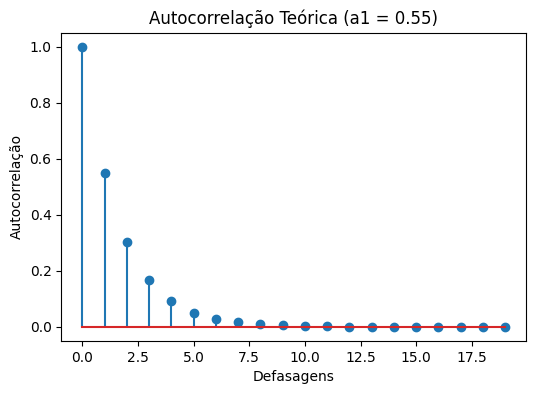

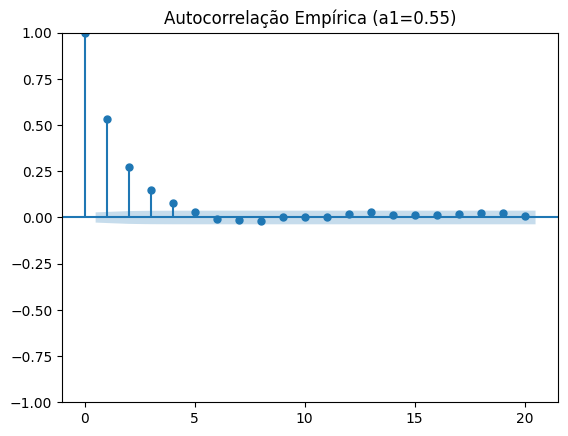

Valores teóricos (a1=-0.75): Média=0.171, Variância=0.023
Valores empíricos (a1=-0.75): Média=0.172, Variância=0.022


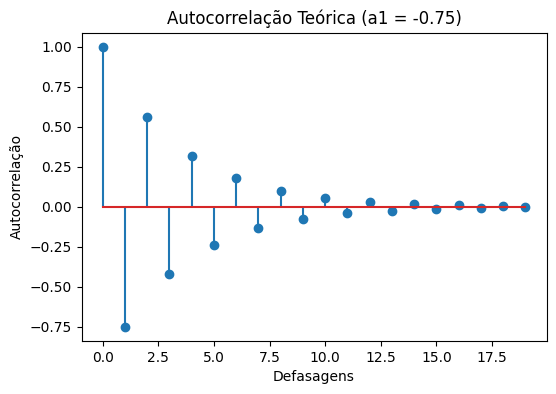

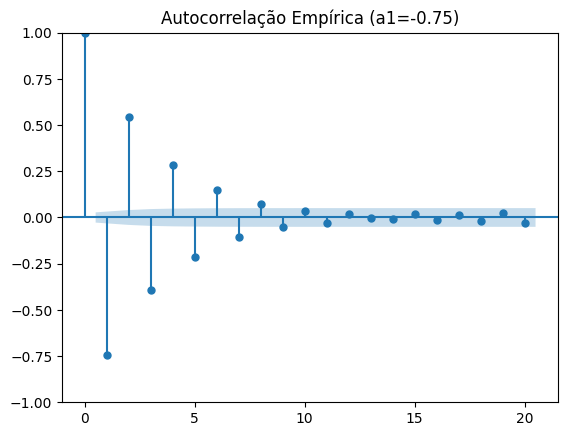

In [116]:
for a1 in valores_a1:
    y = gerar_ar1(a1, tamanho_amostra, a0, variancia_epsilon)

    # Cálculo dos valores teóricos
    media_teorica, variancia_teorica = calcular_teorico(a1, a0, variancia_epsilon)
    print(f"Valores teóricos (a1={a1}): Média={media_teorica:.3f}, Variância={variancia_teorica:.3f}")

    # item C: Cálcul dos valores empíricos
    media_empirica = np.mean(y)
    variancia_empirica = np.var(y)
    print(f"Valores empíricos (a1={a1}): Média={media_empirica:.3f}, Variância={variancia_empirica:.3f}")

    # Item B: Gráfico de autocorrelação teórica
    plotar_acf_teorica(a1)

    # item D: Gráfico de autocorrelação empírica
    plot_acf(y, lags=20, title=f'Autocorrelação Empírica (a1={a1})')
    plt.show()

## Item E

In [111]:
def estimar_a1(series):
    modelo = AutoReg(series, lags=1, old_names=False)  # Modelo AR(1)
    resultado = modelo.fit()
    return resultado.params[1]

for i, a1 in enumerate(valores_a1):
    y = gerar_ar1(a1, tamanho_amostra, a0, variancia_epsilon)
    a1_estimado = estimar_a1(y)
    print(f"Série {i + 1}: Valor real de a1 = {a1}, Valor estimado de a1 = {a1_estimado:.3f}")


Série 1: Valor real de a1 = 0.55, Valor estimado de a1 = 0.566
Série 2: Valor real de a1 = -0.75, Valor estimado de a1 = -0.752


# Questão 2

## item A

In [77]:
dados, freq_amostragem = sf.read("/content/drive/MyDrive/Estocásticos 2024.2 /Trabalho 2/audio_questao2/audio_2025-03-08_14-58-15.ogg")

print(f"Frequência de amostragem: {freq_amostragem} Hz")
print(f"Duração: {len(dados) / freq_amostragem} segundos")


Frequência de amostragem: 48000 Hz
Duração: 4.2935 segundos


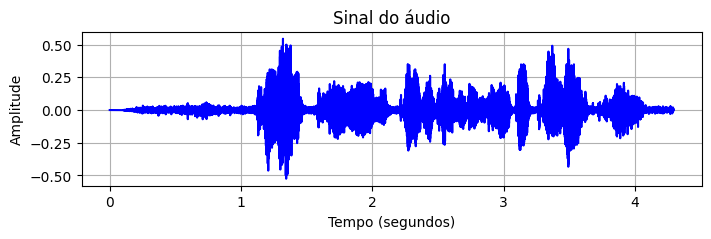

In [78]:
tempo = np.linspace(0, len(dados) / freq_amostragem, num=len(dados))

plt.figure(figsize=(8, 2))
plt.plot(tempo, dados, color="blue")
plt.title("Sinal do áudio")
plt.xlabel("Tempo (segundos)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

## item B

SNR (Relação Sinal-Ruído): -4.35 dB


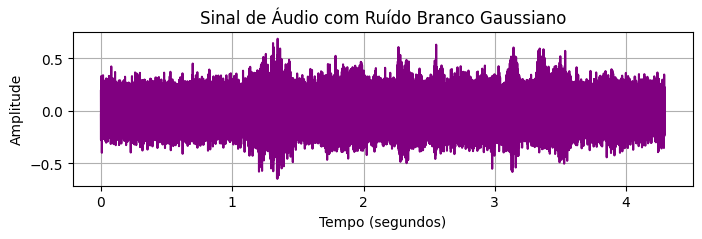

In [79]:
sinal = dados
variancia_ruido = 0.01
ruido = np.random.normal(0, np.sqrt(variancia_ruido), len(sinal))
sinal_ruidoso = sinal + ruido

# Cálculo da a relação sinal-ruído
potencia_sinal = np.mean(sinal**2)  # Potência do sinal original
potencia_ruido = np.mean(ruido**2)  # Potência do ruído
snr = 10 * np.log10(potencia_sinal / potencia_ruido)  # Relação SNR em dB

print(f"SNR (Relação Sinal-Ruído): {snr:.2f} dB")

tempo = np.linspace(0, len(sinal) / freq_amostragem, num=len(sinal))
plt.figure(figsize=(8, 2))
plt.plot(tempo, sinal_ruidoso, color="purple")
plt.title("Sinal de Áudio com Ruído Branco Gaussiano")
plt.xlabel("Tempo (segundos)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


## item C

In [80]:
def suavizacao_exponencial(sinal, alpha):
    sinal_filtrado = np.zeros(len(sinal))
    sinal_filtrado[0] = sinal[0]
    for t in range(1, len(sinal)):
        sinal_filtrado[t] = alpha * sinal[t] + (1 - alpha) * sinal_filtrado[t-1]
    return sinal_filtrado

In [81]:
def medias_moveis_causal(sinal, janela):
    sinal_filtrado = np.convolve(sinal, np.ones(janela) / janela, mode='valid')
    return np.pad(sinal_filtrado, (janela-1, 0), mode='constant')

In [82]:
def medias_moveis_nao_causal(sinal, janela):
    sinal_filtrado = np.convolve(sinal, np.ones(janela) / janela, mode='same')
    return sinal_filtrado

In [83]:
def calcular_snr(sinal_original, sinal_filtrado):
    potencia_sinal = np.mean(sinal_original**2)
    potencia_ruido = np.mean((sinal_original - sinal_filtrado)**2)
    return 10 * np.log10(potencia_sinal / potencia_ruido)

# Hiperparâmetros a serem testados
alphas = np.linspace(0.1, 0.9, 9)  # Para suavização exponencial
janelas = [3, 5, 7, 9]    # Para médias móveis

melhor_alpha, melhor_snr_exp = 0, -np.inf
for alpha in alphas:
    sinal_suavizado = suavizacao_exponencial(sinal_ruidoso, alpha)
    snr_exp = calcular_snr(sinal, sinal_suavizado)
    if snr_exp > melhor_snr_exp:
        melhor_alpha, melhor_snr_exp = alpha, snr_exp

melhor_janela_causal, melhor_snr_causal = 0, -np.inf
for janela in janelas:
    sinal_causal = medias_moveis_causal(sinal_ruidoso, janela)
    snr_causal = calcular_snr(sinal, sinal_causal)
    if snr_causal > melhor_snr_causal:
        melhor_janela_causal, melhor_snr_causal = janela, snr_causal

melhor_janela_nao_causal, melhor_snr_nao_causal = 0, -np.inf
for janela in janelas:
    sinal_nao_causal = medias_moveis_nao_causal(sinal_ruidoso, janela)
    snr_nao_causal = calcular_snr(sinal, sinal_nao_causal)
    if snr_nao_causal > melhor_snr_nao_causal:
        melhor_janela_nao_causal, melhor_snr_nao_causal = janela, snr_nao_causal


In [84]:
print("Resultados:")
print(f"Suavização Exponencial | Hiperparâmetro (α): {melhor_alpha:.2f} | SNR: {melhor_snr_exp:.2f} dB")
print(f"Médias Móveis (Causal)  | Hiperparâmetro (Janela): {melhor_janela_causal} | SNR: {melhor_snr_causal:.2f} dB")
print(f"Médias Móveis (Não-Causal) | Hiperparâmetro (Janela): {melhor_janela_nao_causal} | SNR: {melhor_snr_nao_causal:.2f} dB")

Resultados:
Suavização Exponencial | Hiperparâmetro (α): 0.10 | SNR: 2.45 dB
Médias Móveis (Causal)  | Hiperparâmetro (Janela): 9 | SNR: 1.67 dB
Médias Móveis (Não-Causal) | Hiperparâmetro (Janela): 9 | SNR: 2.36 dB


Todos os métodos apresentaram relação sinal-ruído (SNR) positiva após a filtragem, indicando que a potência do sinal original ultrapassou a potência do ruído. Isso mostra que os filtros ajudaram a reduzir o ruído do sinal. A suavização exponencial teve o maior impacto em comparação com os outros.

# Questão 3

Analisando o áudio: audio1.wav
Duração do áudio: 8.64 segundos
Taxa de amostragem: 11025 Hz
Frequência Fundamental: 1047.21 Hz




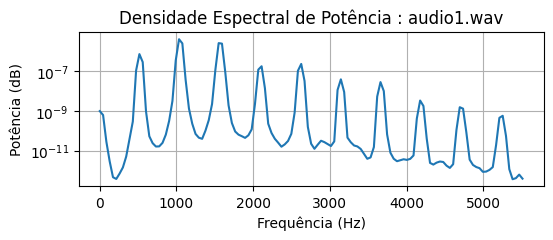

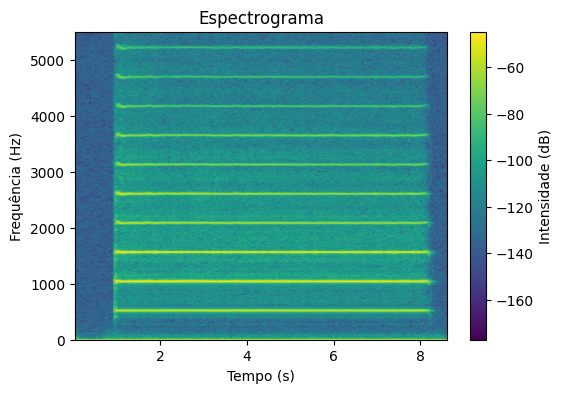

Analisando o áudio: audio2.wav
Duração do áudio: 3.33 segundos
Taxa de amostragem: 11025 Hz
Frequência Fundamental: 1063.20 Hz




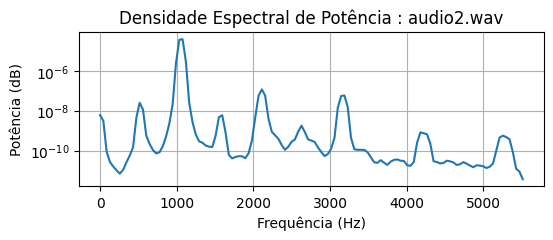

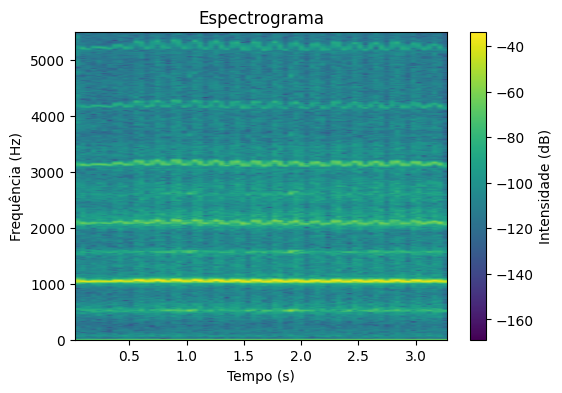

Analisando o áudio: audio3.wav
Duração do áudio: 3.51 segundos
Taxa de amostragem: 11025 Hz
Frequência Fundamental: 385.80 Hz




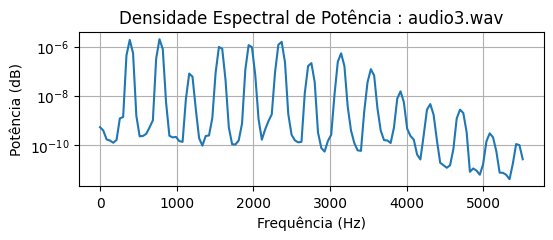

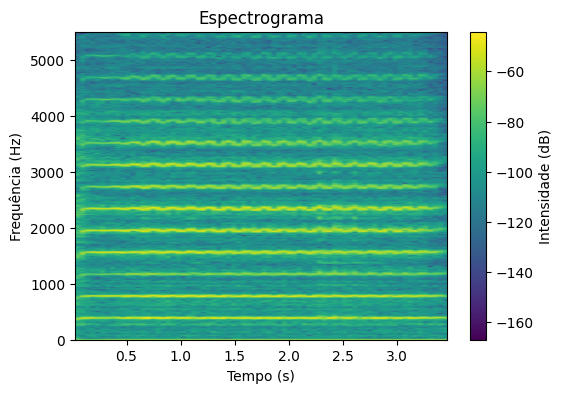

In [85]:
caminho_audios = ["/content/drive/MyDrive/Estocásticos 2024.2 /Trabalho 2/audio_instrumentos/audio1.wav",
                  "/content/drive/MyDrive/Estocásticos 2024.2 /Trabalho 2/audio_instrumentos/audio2.wav",
                  "/content/drive/MyDrive/Estocásticos 2024.2 /Trabalho 2/audio_instrumentos/audio3.wav"]

for caminho_audio in caminho_audios:
  nome_audio = caminho_audio.split("/")[-1]
  print(f"Analisando o áudio: {nome_audio}")
  sinal, taxa_amostragem = sf.read(caminho_audio)

  print(f"Duração do áudio: {len(sinal) / taxa_amostragem:.2f} segundos")
  print(f"Taxa de amostragem: {taxa_amostragem} Hz")

  # Item A: Frequência fundamental
  espectro = np.abs(np.fft.rfft(sinal))
  frequencias = np.fft.rfftfreq(len(sinal), d=1/taxa_amostragem)

  indice_fundamental = np.argmax(espectro)
  frequencia_fundamental = frequencias[indice_fundamental]

  print(f"Frequência Fundamental: {frequencia_fundamental:.2f} Hz")
  print("\n")

  # item B: Densidade espectral de potência
  frequencias, psd = welch(sinal, fs=taxa_amostragem)

  plt.figure(figsize=(6, 2))
  plt.semilogy(frequencias, psd)
  plt.title(f"Densidade Espectral de Potência : {nome_audio}")
  plt.xlabel("Frequência (Hz)")
  plt.ylabel("Potência (dB)")
  plt.grid()
  plt.show()

  # item C: espectrograma
  plt.figure(figsize=(6,4))
  plt.specgram(sinal, NFFT=1024, Fs=taxa_amostragem, noverlap=512, cmap="viridis")
  plt.title("Espectrograma")
  plt.xlabel("Tempo (s)")
  plt.ylabel("Frequência (Hz)")
  plt.colorbar(label="Intensidade (dB)")
  plt.show()



Ao comparar os gráficos de espectrograma é possível notar que eles tem características diferentes. Então, considero que alguém com conhecimento na área conseguiria diferenciar os instrumentos ao analisar sua frequência fundamental, intensidade e densidade espectral.

# Questão 4

In [99]:
data = pd.read_csv('/content/drive/MyDrive/Estocásticos 2024.2 /Trabalho 2/audio_questao4/maribond.dat', delim_whitespace=True, header=None)

<ipython-input-99-981fe0502989>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('/content/drive/MyDrive/Estocásticos 2024.2 /Trabalho 2/audio_questao4/maribond.dat', delim_whitespace=True, header=None)


## Item A

Série temporal

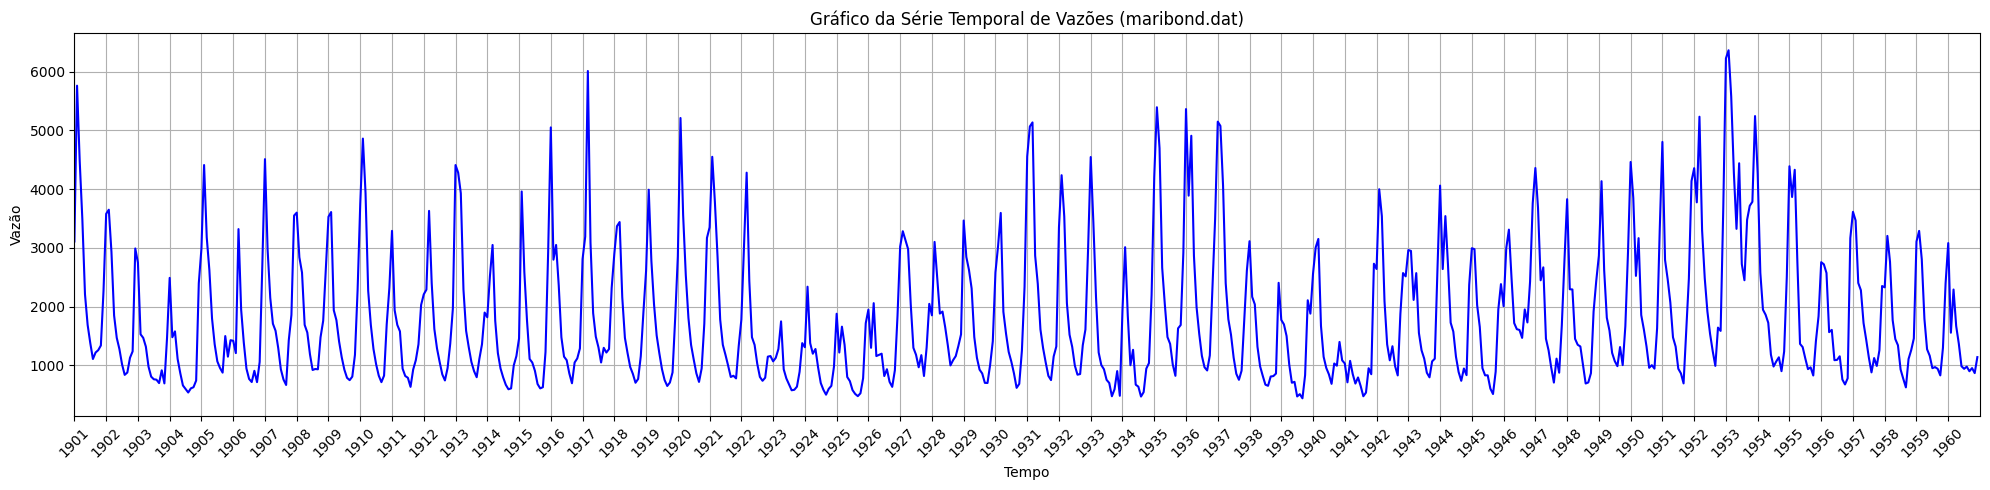

In [87]:
time_series = data.values.flatten()

anos = np.arange(1901, 1901 + data.shape[0])  # Supondo 60 anos a partir de 1901 (anos fictícios para ilustrar no gráfico)
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
rotulos_eixo_x = [f'{ano}-{mes}' for ano in anos for mes in meses]

plt.figure(figsize=(20, 5))
plt.plot(range(len(time_series)), time_series, label='Série Temporal', color='blue')
plt.title('Gráfico da Série Temporal de Vazões (maribond.dat)')
plt.xlim(0, len(time_series))
plt.xlabel('Tempo')
plt.ylabel('Vazão')
plt.xticks(ticks=np.arange(0, len(time_series), 12), labels=anos, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Histograma

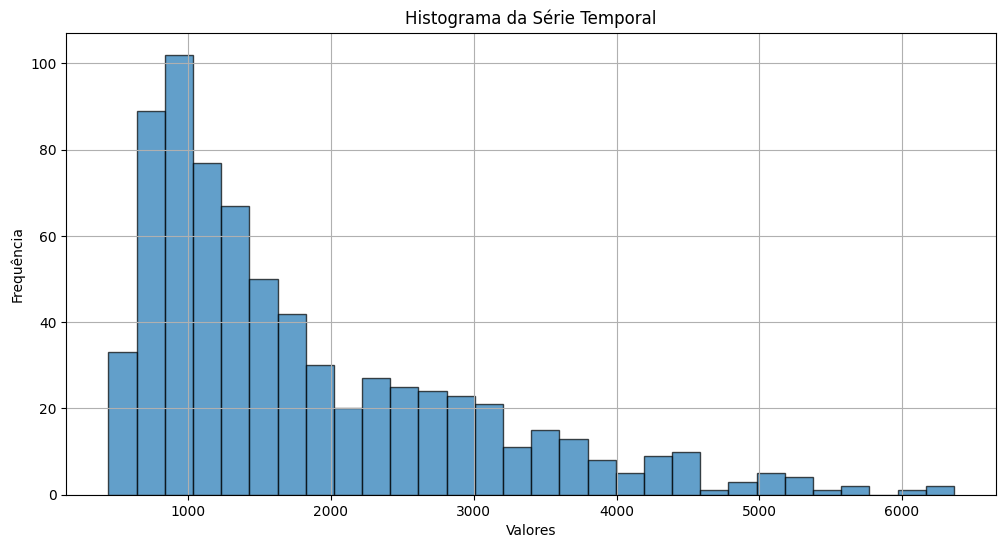

In [88]:
plt.figure(figsize=(12, 6))
plt.hist(time_series, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histograma da Série Temporal')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

Função de autocorrelação

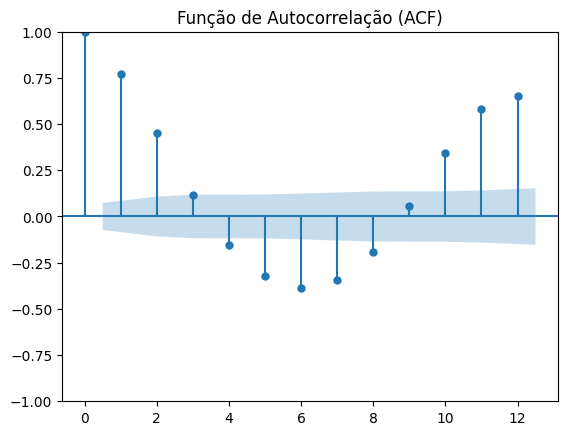

In [89]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

sm.graphics.tsa.plot_acf(time_series, lags=12)
plt.title('Função de Autocorrelação (ACF)')
plt.show()


In [90]:
# Cálculo da autocorrelação manualmente
def autocorr(x, lag):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1] if lag > 0 else 1.0

autocorr_values = [autocorr(time_series, lag) for lag in range(12)]

# Exibir os valores de autocorrelação
for lag, value in enumerate(autocorr_values):
    print(f"Lag {lag}: {value}")


Lag 0: 1.0
Lag 1: 0.7698433180845757
Lag 2: 0.4548844571419544
Lag 3: 0.11984894227550126
Lag 4: -0.15918606513744724
Lag 5: -0.3288317732018544
Lag 6: -0.3953885000057992
Lag 7: -0.35009742360462565
Lag 8: -0.19396794900852599
Lag 9: 0.05649993202800713
Lag 10: 0.34850959441496654
Lag 11: 0.5902038119966635


## Item B

Dessazonalização

In [91]:
# Transformação logarítmica
log_data = np.log(data)

mu = log_data.mean(axis=0)  # Média por coluna (mês)
sigma = log_data.std(axis=0)  # Desvio padrão por coluna (mês)

z_data = (log_data - mu) / sigma

z_series = z_data.values.flatten()


Série temporal

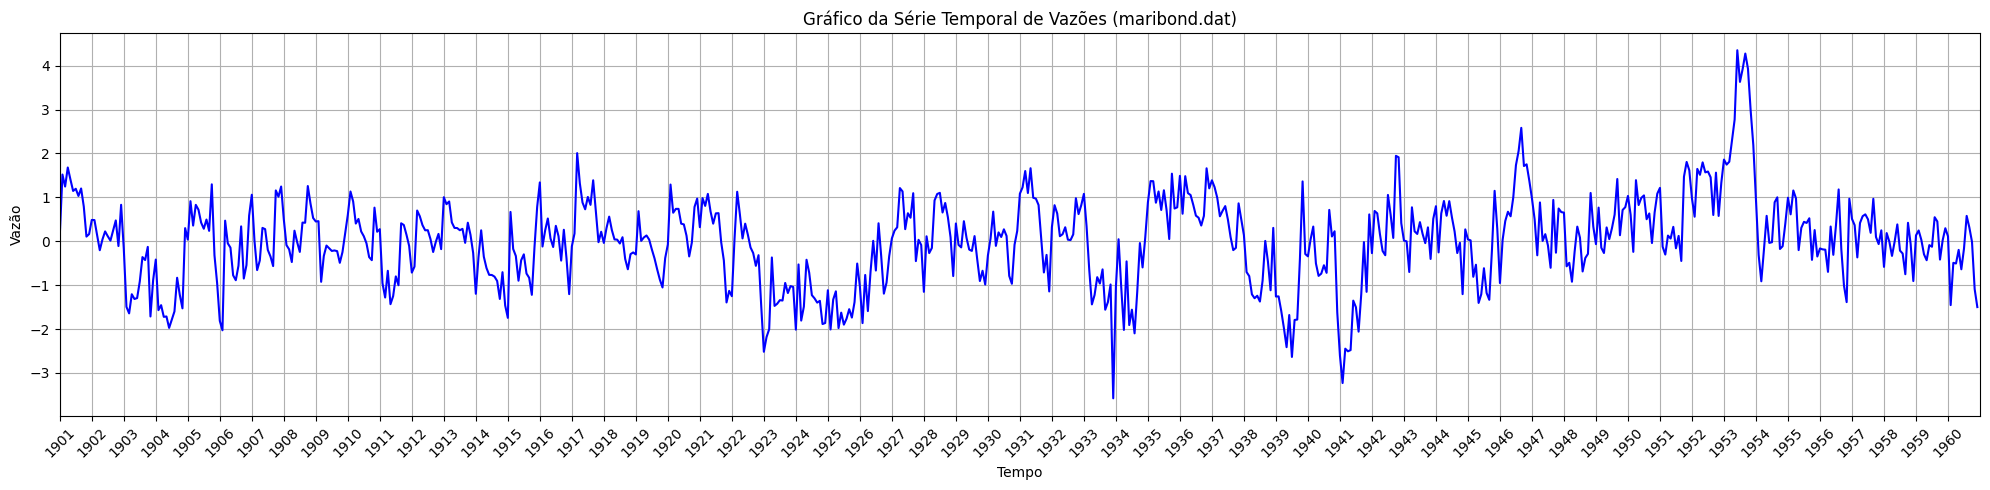

In [92]:
time_series = z_series

anos = np.arange(1901, 1901 + data.shape[0])  # Supondo 60 anos a partir de 1901 (anos fictícios para ilustrar no gráfico)
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
rotulos_eixo_x = [f'{ano}-{mes}' for ano in anos for mes in meses]

plt.figure(figsize=(20, 5))
plt.plot(range(len(time_series)), time_series, label='Série Temporal', color='blue')
plt.title('Gráfico da Série Temporal de Vazões (maribond.dat)')
plt.xlim(0, len(time_series))
plt.xlabel('Tempo')
plt.ylabel('Vazão')
plt.xticks(ticks=np.arange(0, len(time_series), 12), labels=anos, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Histograma

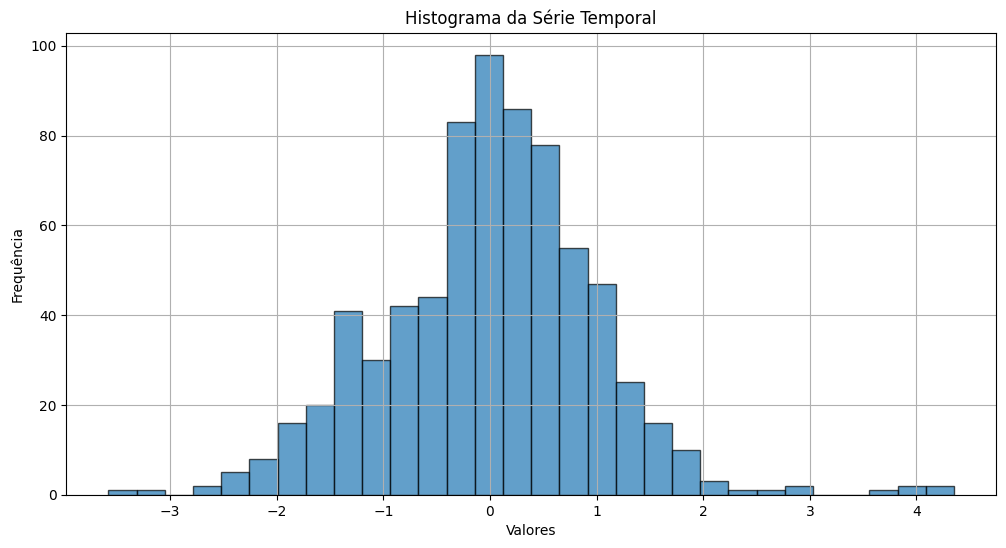

In [93]:
plt.figure(figsize=(12, 6))
plt.hist(time_series, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histograma da Série Temporal')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

Função de autocorrelação

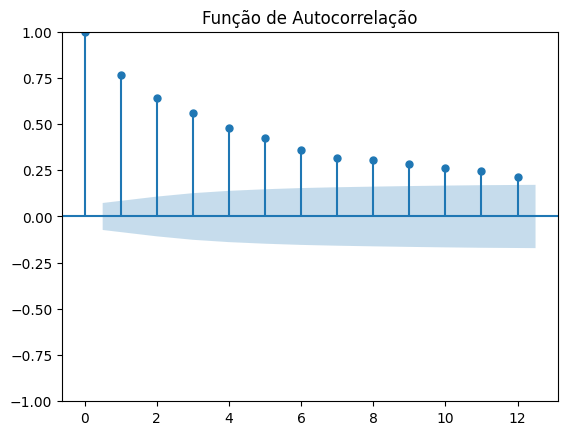

In [94]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

sm.graphics.tsa.plot_acf(time_series, lags=12)
plt.title('Função de Autocorrelação')
plt.show()


In [95]:
# Cálculo da autocorrelação manualmente
def autocorr(x, lag):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1] if lag > 0 else 1.0

autocorr_values = [autocorr(time_series, lag) for lag in range(12)]

# Exibir os valores de autocorrelação
for lag, value in enumerate(autocorr_values):
    print(f"Lag {lag}: {value}")


Lag 0: 1.0
Lag 1: 0.7650766097861544
Lag 2: 0.6422946680987681
Lag 3: 0.5614181255888441
Lag 4: 0.4836669616426231
Lag 5: 0.4311629307500854
Lag 6: 0.36127832716646446
Lag 7: 0.32160924348625153
Lag 8: 0.3084153013246685
Lag 9: 0.28674005931061264
Lag 10: 0.26534773088146807
Lag 11: 0.2477873228429289


Conforme explicado nos slides, devido à transformação logarítmica, a distribuição normalizada Z tende a estar mais próxima de uma gaussiana, esse fato pode ser comprovado ao compararmos o histograma do item A com o histograma gerado no item B (o qual apresenta uma distribuição próxima ao formato gaussiano). Além disso, pode-se perceber que a função de autocorrelação decai de forma ligeiramente exponencial.

## Item C

In [96]:
time_series = pd.Series(data.values.flatten())

# Ajuste do modelo AR(1)
model = ARIMA(time_series, order=(1, 0, 0))
result = model.fit()

a1 = result.params['ar.L1']
print(f"Coeficiente estimado (a1): {a1}")

Coeficiente estimado (a1): 0.7696578667124602


Resíduos calculados:
0    1303.080552
1    2950.154354
2    -369.438993
3    -374.276923
4    -892.315635
dtype: float64


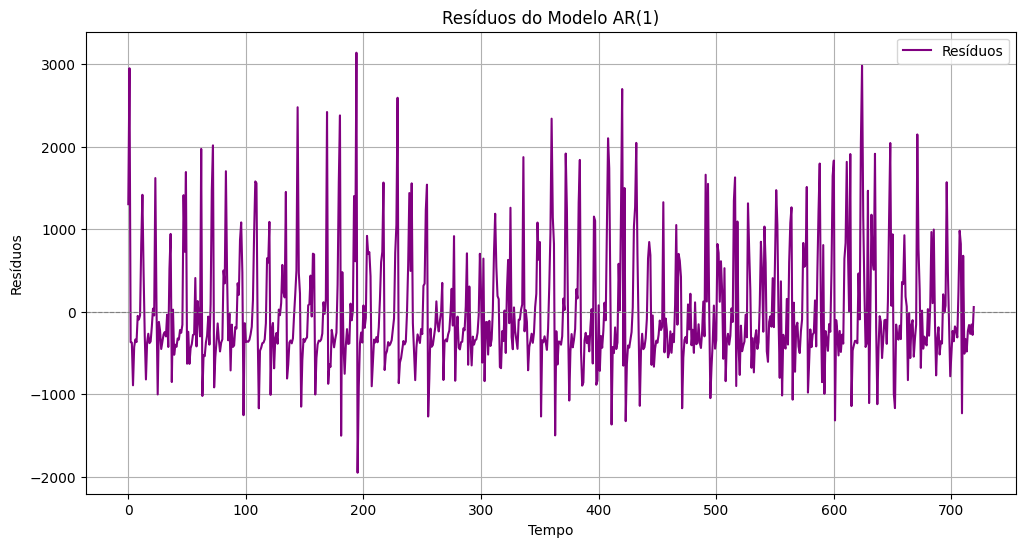

In [97]:
residuos = result.resid
print("Resíduos calculados:")
print(residuos.head())

plt.figure(figsize=(12, 6))
plt.plot(residuos, label="Resíduos", color="purple")
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Resíduos do Modelo AR(1)")
plt.xlabel("Tempo")
plt.ylabel("Resíduos")
plt.legend()
plt.grid(True)
plt.show()

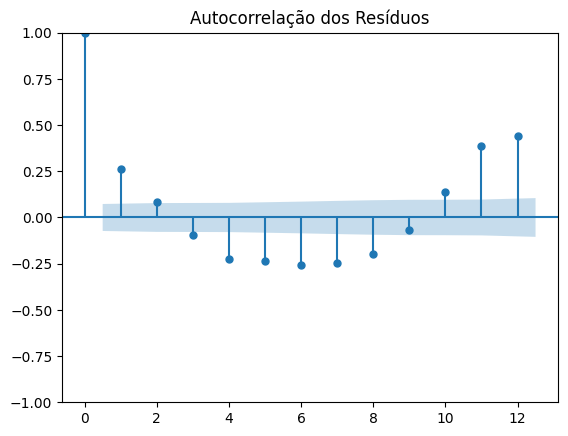

In [98]:
import statsmodels.api as sm

# Plotar a Função de Autocorrelação dos resíduos
sm.graphics.tsa.plot_acf(residuos, lags=12)
plt.title("Autocorrelação dos Resíduos")
plt.show()


No item B é possível notar um decaimento exponencial da autocorrelação, o que indica uma perda possível perda de sazonalidade. Já no item C, podemos observar que ainda há autocorrelações significativas não explicadas pelo modelo, além do formato "cíclico" apresentado no gráfico, semelhante ao FAC do item A(dados com sazonalidade). No entanto, em valores "brutos", as medidas de autocorrelação do modelo do item C estão mais próximas de 0 do que as do item B.